In [1]:
import pandas as pd
import numpy as np
import sys, os

import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm

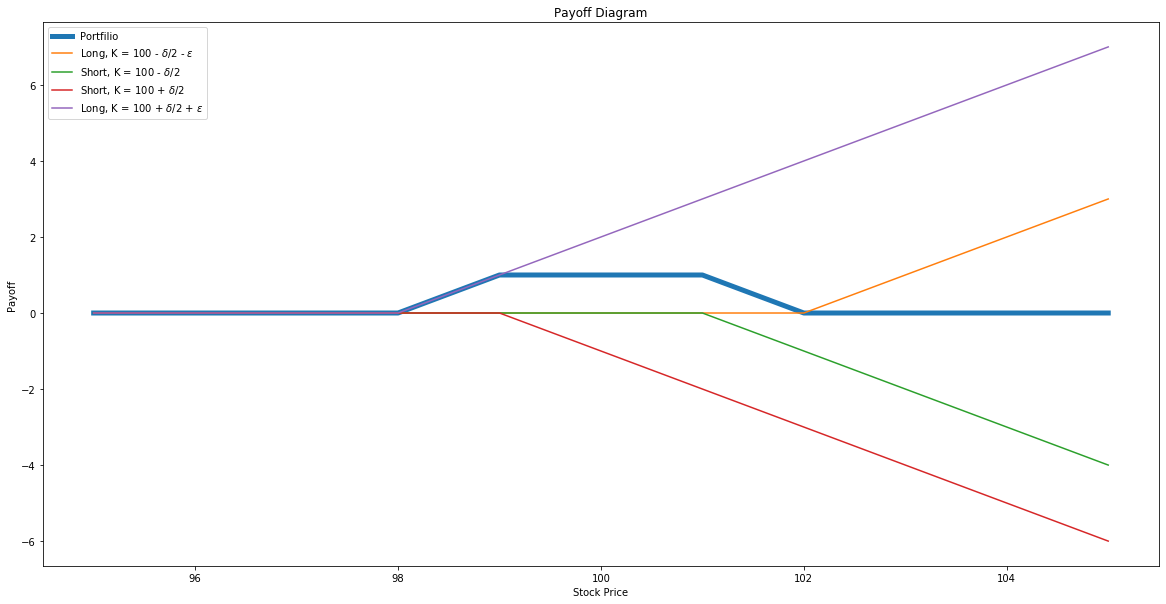

In [2]:
x = np.arange(95, 106)

rg = []

p1 = []
p2 = []
p3 = []
p4 = []

delta = 2
eps = 1
K = 100

for v in x:
        
    p1.append(max(v - K - delta / 2 - eps, 0))
    p2.append(-1 * max(v - K - delta / 2, 0))
    p3.append(-1 * max(v - K + delta / 2, 0))
    p4.append(max(v - K + delta/2 + eps, 0))
    
    rg.append(p1[-1] + p2[-1] + p3[-1] + p4[-1])

plt.figure(figsize=(20, 10))
plt.title("Payoff Diagram")
plt.xlabel("Stock Price")
plt.ylabel("Payoff")
plt.plot(x, rg, label="Portfilio", linewidth=5)
plt.plot(x, p1, label="Long, K = 100 - $\delta/2$ - $\epsilon$")
plt.plot(x, p2, label="Short, K = 100 - $\delta/2$")
plt.plot(x, p3, label="Short, K = 100 + $\delta/2$")
plt.plot(x, p4, label="Long, K = 100 + $\delta/2$ + $\epsilon$")
plt.legend()
plt.savefig("plots/rnd_mock_position.png")

### Calculations

In [3]:
OTYPE = "C"
if OTYPE == "C":
    title = "Implied Call Distribution"
else:
    title = "Implied Put Distribution"

In [4]:
options = pd.read_csv("data/options.csv")

S = options.stock_price.values
K = options.strike_price.values
q = np.log(1 + options.dividend_yield / 100).values
r = np.log(1 + options.rate).values
v = options.bivs.values
T = (options.tdays_to_expiry / 252).values

d2 = np.log(S / K) + (r - q - 0.5 * v * v) * T
d2 /= np.sqrt(T) * v
d2 *= 1 if OTYPE == "C" else -1
nd2 = norm.cdf(d2)
options['d2'] = d2
options['nd2'] = nd2
options['ert'] = np.exp(-r * T)
options['kprime'] = options.nd2 * options.ert

options = options[options.tdays_to_expiry < 400]
options = options[options.tdays_to_expiry > 10]
options = options[options.bivs > 0]

/home/zquantz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/home/zquantz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/home/zquantz/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/zquantz/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/zquantz/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1827: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= np.asarray(_b)) & cond0


### Full Code

In [5]:
def find_rnd(exp):
    
    if OTYPE == "C":
        rnd = [
            exp.kprime.values[0] - p
            for p in exp.kprime
        ]
    else:
        rnd = [
            p - exp.kprime.values[0]
            for p in exp.kprime
        ]
    rnd = pd.Series(rnd)
    rnd = rnd.rolling(5, min_periods=1).median()
    rnd = rnd.diff()

    if rnd.min() < 0:
        rnd = rnd + abs(rnd.min())
    rnd = rnd / rnd.sum()

    _strikes = pd.DataFrame()
    _strikes['rnd'] = rnd
    _strikes['strike_price'] = exp.strike_price.values
    _strikes = strikes.merge(_strikes, on="strike_price", how="outer")
    _strikes = _strikes.fillna(0)

    return _strikes

data = []
for date in options.date_current.unique():
    
    print(date)
    
    tmp = options[options.date_current == date]
    tmp = tmp[tmp.option_type == OTYPE]
    
    spu = tmp.strike_price.unique()
    spmin = (int(spu.min() / 5) * 5)
    spmax = (int(spu.max() / 5) * 5)
    
    strikes = tmp.strike_price.sort_values().unique()
    strikes = pd.DataFrame(strikes, columns = ['strike_price'])
    bins = list(range(spmin, spmax, 5))
    
    strikes = tmp.strike_price.sort_values().unique()
    strikes = pd.DataFrame(strikes, columns = ['strike_price'])
    
    rnds = tmp.groupby("expiration_date").apply(find_rnd)
    rnds = rnds.reset_index(level=0).reset_index(drop=True)
    rnds['bins'] = pd.cut(rnds.strike_price, bins)
    rnds = rnds.groupby(["expiration_date", "bins"])
    rnds = rnds.apply(lambda x: x['rnd'].sum())
    rnds = rnds.reset_index(name="rnd")
    rnds = rnds.pivot(*rnds.columns)
    
    bins = np.array(bins) / tmp.stock_price.values[0]
    bins = bins * 100
    X, Y = np.meshgrid(bins[:rnds.shape[1]], tmp.tdays_to_expiry.unique())
    Z = rnds.values
    data.append([
        date,
        X,
        Y,
        Z
    ])

2019-11-06
2019-11-07
2019-11-08
2019-11-12
2019-11-13
2019-11-14
2019-11-15
2019-11-18
2019-11-19
2019-11-20
2019-11-21
2019-11-22
2019-11-25
2019-11-26
2019-11-27
2019-11-29
2019-12-02
2019-12-03
2019-12-04
2019-12-05
2019-12-06
2019-12-09
2019-12-10
2019-12-11
2019-12-12
2019-12-13
2019-12-16
2019-12-17
2019-12-18
2019-12-19
2019-12-20
2019-12-23
2019-12-24
2019-12-26
2019-12-27
2019-12-30
2019-12-31
2020-01-02
2020-01-03
2020-01-06
2020-01-07
2020-01-08
2020-01-09
2020-01-10
2020-01-13
2020-01-14
2020-01-15
2020-01-16
2020-01-17
2020-01-21
2020-01-22
2020-01-23
2020-01-24
2020-01-27
2020-01-28
2020-01-29
2020-01-30
2020-01-31
2020-02-03
2020-02-04
2020-02-05
2020-02-06
2020-02-07
2020-02-10
2020-02-11
2020-02-12
2020-02-13
2020-02-14
2020-02-18
2020-02-19
2020-02-20
2020-02-21
2020-02-24
2020-02-25
2020-02-26
2020-02-27
2020-02-28
2020-03-02
2020-03-03
2020-03-04
2020-03-05
2020-03-06
2020-03-09
2020-03-10
2020-03-11
2020-03-12
2020-03-13
2020-03-16
2020-03-17
2020-03-18
2020-03-19

In [9]:
%matplotlib tk
def plot_density(n, data, ax):
    
    date, X, Y, Z = data[n]
        
    ax.clear()
    surf = ax.plot_surface(X, Y, Z, cmap="viridis")
    
    ax.set_title(f"{title} - {date}", pad=10)
    ax.set_xlabel("Moneyness", labelpad=10)
    ax.set_ylabel("T Days to Expiry", labelpad=10)
    ax.set_zlabel("Density", labelpad=10)
    ax.view_init(elev=30, azim=70)
    ax.set_xlim(60, 140)
    ax.set_ylim(0, 400)
    ax.invert_xaxis()
    
    return surf
    
fig = plt.figure(figsize=(20, 11))
ax = fig.add_subplot(111, projection='3d')
surf_ani = animation.FuncAnimation(fig, plot_density, fargs=(data, ax), frames=len(data), interval=150, blit=False)
surf_ani.save(f"plots/density_year_in_review_{OTYPE}.mp4")

In [10]:
date, X, Y, Z = data[100]

In [11]:
f, ax = plt.subplots(1, 2, figsize=(9, 4))
ax[0].plot(X[5, :], Z[5, :])
ax[0].set_xlabel("Moneyness")
ax[0].set_ylabel("f(x)")

ax[1].plot(X[7, :], Z[7, :])
ax[1].set_xlabel("Moneyness")

plt.savefig("plots/2d_risk_neutrals.png")

In [12]:
f, ax = plt.subplots(1, 2, figsize=(9, 4))
ax[0].plot(X[5, :], Z[5, :].cumsum())
ax[0].set_xlabel("Moneyness")
ax[0].set_ylabel("f(x)")

ax[1].plot(X[7, :], Z[7, :].cumsum())
ax[1].set_xlabel("Moneyness")

plt.savefig("plots/2d_risk_neutral_cdfs.png")